In [22]:
import sys
sys.path.append('/home/sensei/jupy-notebooks/Analytics/PorterFarms/')
print("============================================")
print("/  PacketCountsByHour is running.          /")
print("============================================")
from datetime import datetime, timedelta
import pytz
import json
import copy
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import configparser

config = configparser.ConfigParser()
config.read("../../../analytics_secrets.ini")

_ACTIVE_STANDBY = config['DEFAULT']['role']
if _ACTIVE_STANDBY == 'STANDBY':
    print("STANDBY")
    raise SystemExit("Stop right there!")
else:
  _SLACK_TOKEN = config['slack']['token']
  _CHIRPSTACK_USER = config['chirpstack']['user']
  _CHIRPSTACK_PASS = config['chirpstack']['password']
  _DB_HOST  = config['kanjidb']['dbhost']
  _DB_PORT  = config['kanjidb']['dbport']  
  _DB_NAME  = config['kanjidb']['dbname']
  _DB_USER  = config['kanjidb']['dbuser']
  _DB_PASS  = config['kanjidb']['dbpass']

  _THRESHOLD_WMA = float(config['analytics']['waterlevelmin'])
  _THRESHOLD_WMAMEAN = 638.0
    
  _UTC_OFFSET = int(config['DEFAULT']['utcoffset'])

  _LOG_DEBUG = 0
  _LOG_INFO  = 1
  _LOG_ERROR = 2
  _LOG_LEVEL = int(config['DEFAULT']['loglevel'])
    
def logger(level, message):
    if level >= _LOG_LEVEL:
      print(message)

logger(_LOG_DEBUG, "{} {} {} {} {}".format(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS))

import kanjiticketing as kt

conn = kt.getKanjiDbConnection(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS)
if conn is not None:
  print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
else:
  print("You are not connected to the database.")

/  PacketCountsByHour is running.          /
Welcome to Jupyter Notebook.  You are connected to the Kanji database!


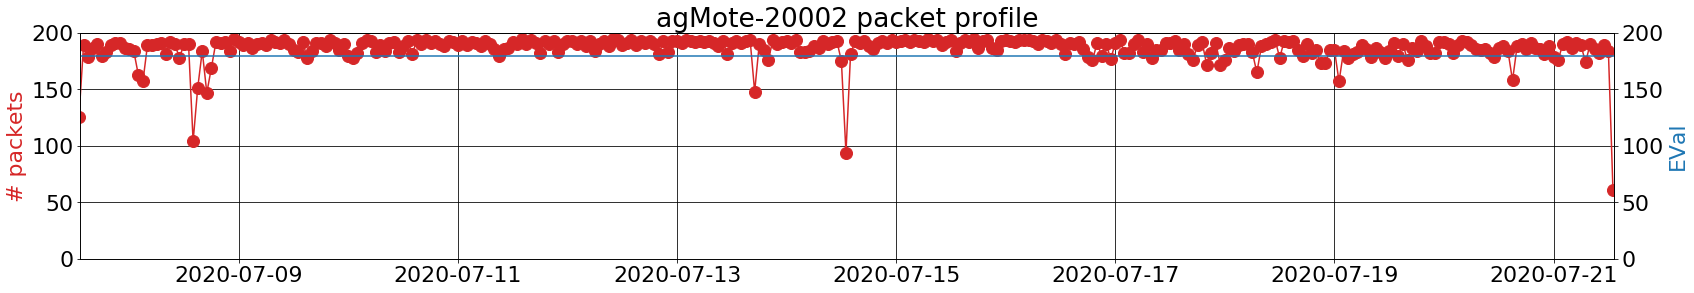

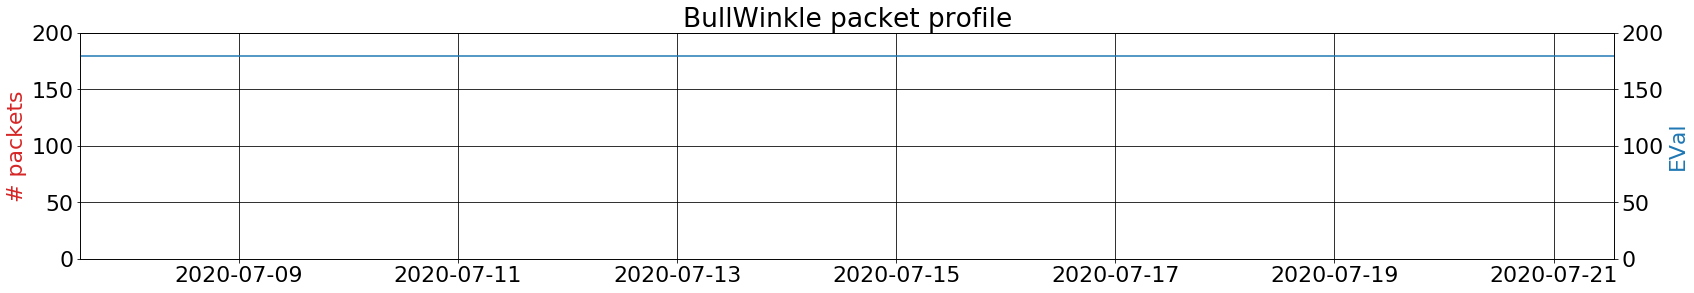

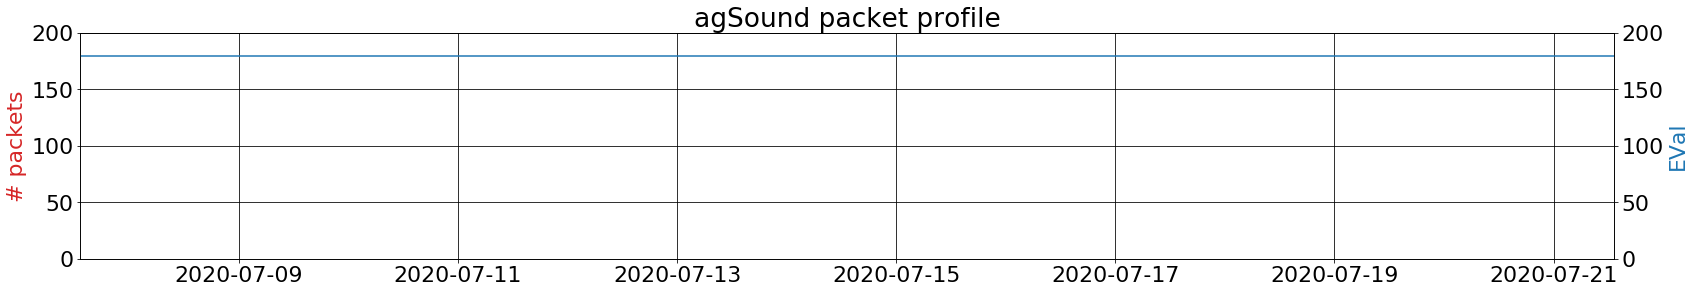

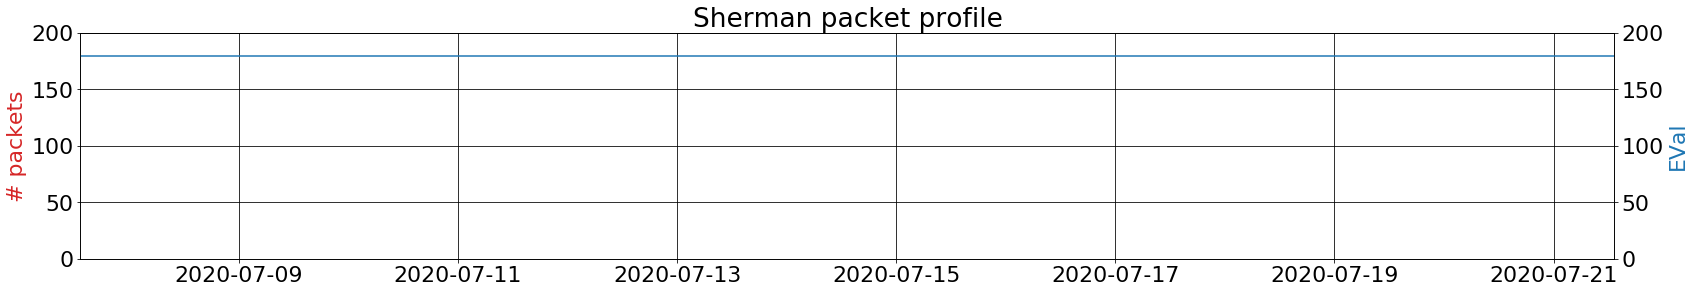

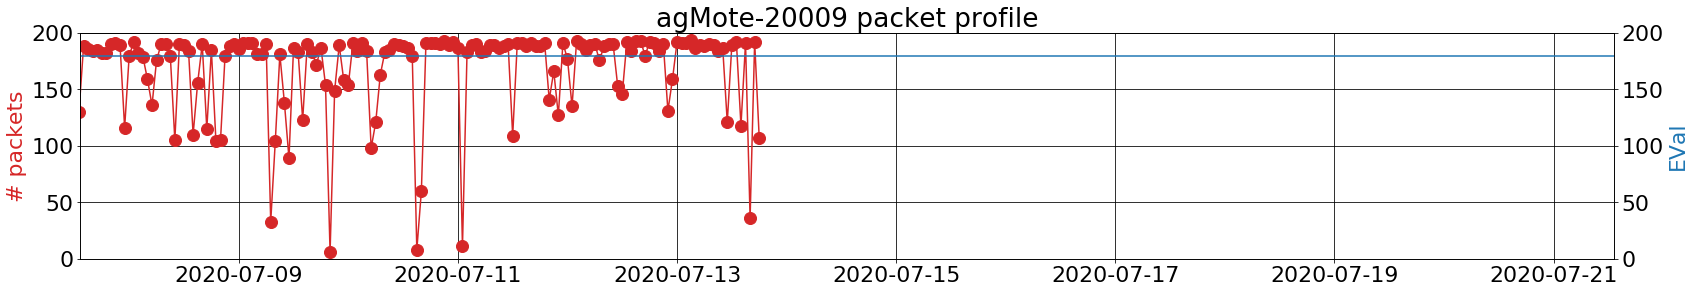

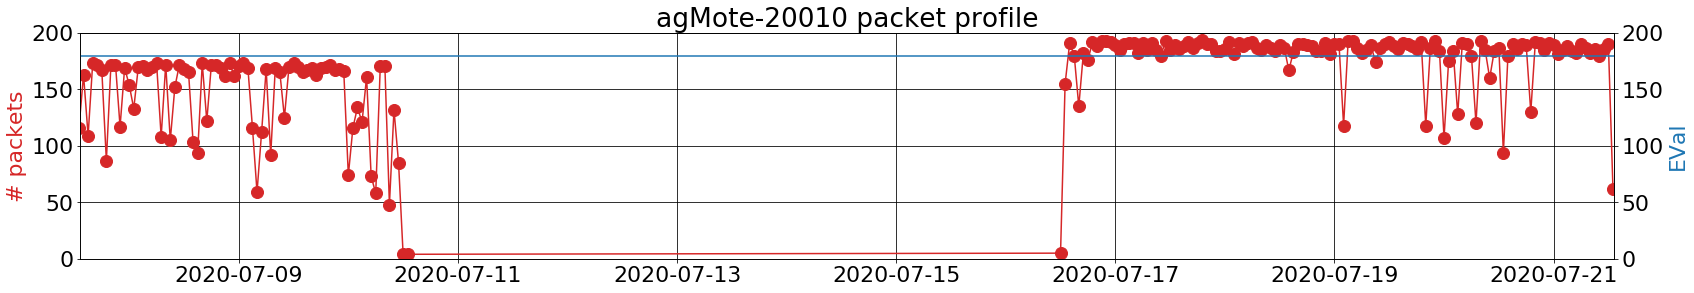

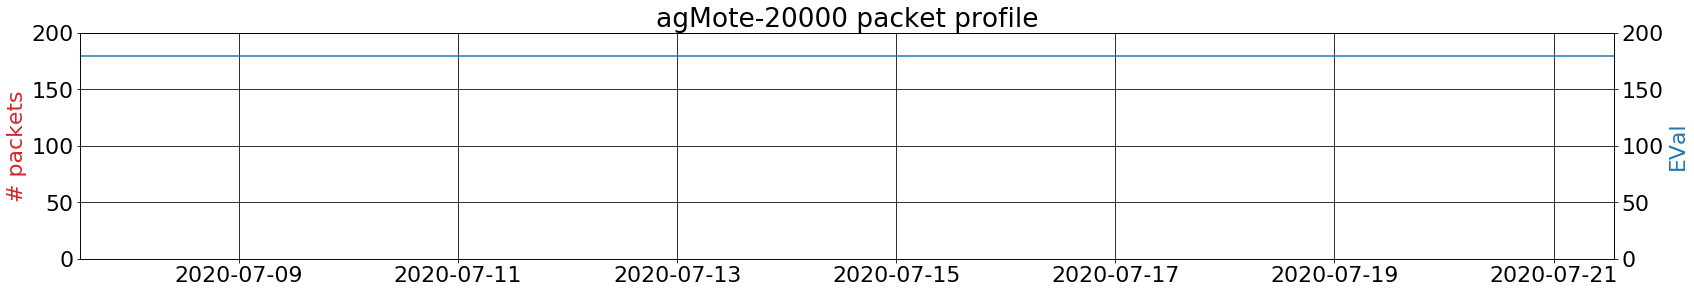

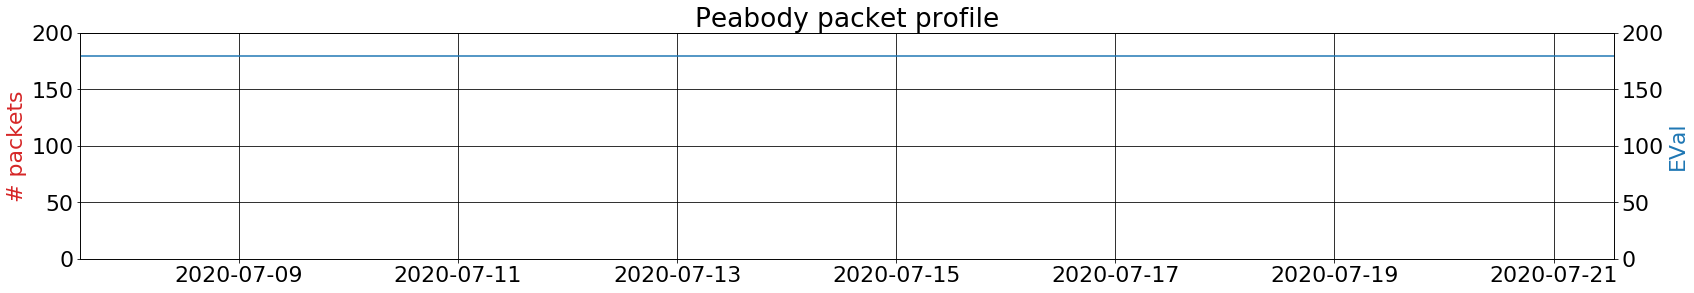

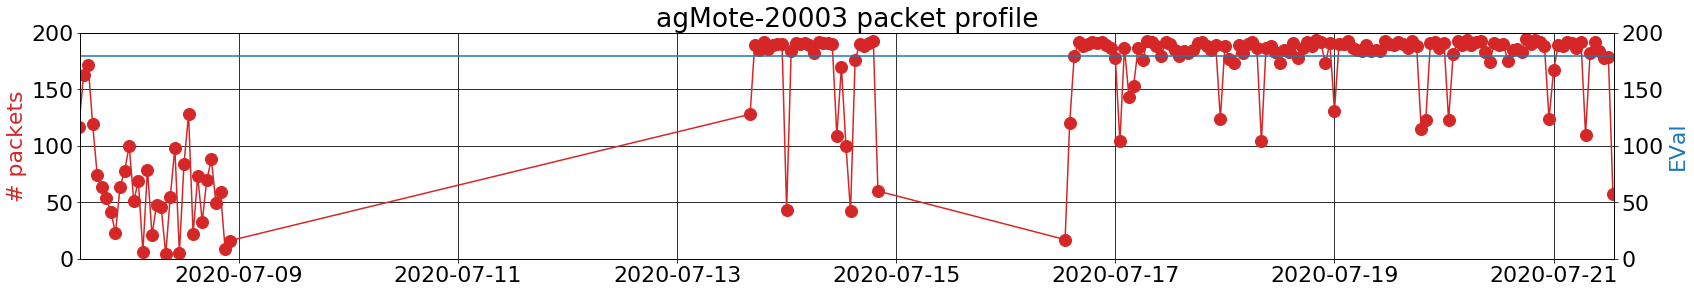

In [23]:
#_LOG_LEVEL = _LOG_DEBUG

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib import dates
register_matplotlib_converters()

_TIME_INTERVAL_HOURS = 168 * 2

now = datetime.now(pytz.utc)  #tz Aware
starttime = now - timedelta(hours=_TIME_INTERVAL_HOURS, minutes=0)
date_rng = pd.date_range(start=starttime, end=now, freq='H')
df = pd.DataFrame(date_rng, columns=['hour'])
df['counts'] = 180
logger(_LOG_DEBUG, df.head(15))
ts_expected = df.set_index('hour')
expected = ts_expected['counts']

nodequery = "SELECT * FROM kanji_node WHERE customer_id=10001;"
#WHERE application_id=10009;"
df0 = pd.read_sql(nodequery, conn)
for ind in df0.index:
  nodeid = df0['idnode'][ind]
  nodename = df0['name'][ind]
  query = "SELECT COUNT(*) AS counts, date_trunc('hour', timestamp) AS hour \
         FROM kanji_eventlog \
         WHERE node_id={} \
         AND timestamp>NOW() - INTERVAL '{} HOURS' \
         GROUP BY hour ORDER BY hour asc;".format(nodeid, _TIME_INTERVAL_HOURS)
     
  logger(_LOG_DEBUG, query)
  df1 = pd.read_sql(query, conn)
  logger(_LOG_DEBUG, df1.head(24))
  ts_actual = df1.set_index('hour')
  logger(_LOG_DEBUG, "hourly ts=\n{}".format(ts_actual))
  actual = ts_actual['counts']
  # Plot the profile
  fig = plt.figure(figsize=(24,8))
  fig.subplots_adjust(top=0.8)
        
  pcolor = 'tab:red'
  tcolor = 'tab:blue'
  hcolor = 'tab:green'
        
  ax1 = fig.add_subplot(211)
  ax1.set_ylabel('# packets', color=pcolor)
  ax1.set_ylim([0, 200])
  ax1.set_xlim([starttime, now])
  
  plt.rc('grid', linestyle="-", color='black')
  plt.grid(True)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.set_ylabel('EVal', color=tcolor)
  ax2.set_ylim([0, 200])

  #ax1.xaxis.set_minor_locator(hours)
          
  ax1.set_title('{} packet profile'.format(nodename))
  ax1.plot(actual, color=pcolor, marker='o', markersize=12)
  ax2.plot(expected, color=tcolor)
  plt.tight_layout()
  plt.show()